In [1]:
# import packages
%pylab inline

import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
from cartopy.util import add_cyclic_point
import matplotlib.pylab as plt
import matplotlib as mpl
from matplotlib import colorbar, colors
from scipy.stats import poisson
import numpy as np
import random
import regionmask
from scipy.stats import linregress

import sys
wython = '/tigress/wenchang/wython'
if wython not in sys.path: sys.path.append(wython)
from xtc import wherebasin

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
# some configurations on the default figure output
%config InlineBackend.figure_format ='retina'
plt.rcParams['figure.dpi'] = 120

### Function to calculate distances between points

In [3]:
import numpy as np

def haversine(lat1, lon1, lat2, lon2):
    # compute distance between 2 points
    
    R = 6371  # Earth radius in kilometers

    # Convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))

    return R * c

# Example
distance_km = haversine(45, 320, 45, 317)
print(distance_km)

235.8665859053396


### Selecting TC basins

Function to only select TCs in a particular basin.
In our case we will use this to specify the Atlantic

In [6]:

from matplotlib import path

def tc_basins(latN=90, latS=-90):
    '''use regionmask to create 8 TC basins'''
    #latN = 90 # north boundary lat
    #latS = -90 # south bounday lat
    name = 'TCBasins'
    names = ['North Atlantic', 'East Pacific', 'West Pacific', 'North Indian',
            'South Indian', 'Australia', 'South Pacific', 'South Atlantic']
    abbrevs = ['NA', 'EP', 'WP', 'NI',
              'SI', 'AU', 'SP', 'SA']
    outlines = [( (295, 0), (260, 20), (260, latN), (360, latN), (360, 0) ),
                ( (200, 0), (200, latN), (260, latN), (260, 20), (295, 0) ),
                ( (105, 0), (105, latN), (200, latN), (200, 0) ),
                ( (30, 0), (30, latN), (105, latN), (105, 0) ),
                ( (30, 0), (30, latS), (105, latS), (105, 0) ),
                ( (105,0), (105, latS), (165, latS), (165, 0) ),
                ( (165, 0), (165, latS), (290, latS), (290, 0) ),
                ( (290, 0), (290, latS), (360, latS), (360, 0) ),
               ]
    numbers = np.arange(len(names))
    # Regions_cls was replaced by Regions since version 0.5.0 of regionmask
    if hasattr(regionmask, 'Regions'):
        Regions = regionmask.Regions
    else:
        Regions = regionmask.Regions_cls
        print('**old versions of regionmask is used: regionmask.Regions_cls**')
    #bs = regionmask.Regions_cls(name=name,
    #bs = regionmask.Regions(name=name,
    bs =             Regions(name=name,
                                numbers=numbers,
                                names=names,
                                abbrevs=abbrevs,
                                outlines=outlines)
    return bs

def tracks_in_basin(ds, basin):
    '''Get the basin bool mask for the tracks dataset.
    **input**:
        ds: tracks dataset;
        basin: basin tag, e.g. "NA" for North Atlantic. 
    **return**:
        in_basin: DataArray of basin mask (bool values)'''
#     ds = xtc.tc_tracks('CTL1860_noleap_tigercpu_intelmpi_18_576PE', years=range(1,11))
#     basin = 'NA'
    # create basin_domain given basin tag, e.g. 'NA' (North Atlantic)
    basins = tc_basins()
    basin_index = basins.map_keys(basin)
    basin_domain = path.Path(basins.coords[basin_index])
    
    # create DataArray of lon/lat pairs
    lon = ds.lon.stack(i_stack=ds.lon.dims)
    lat = ds.lat.stack(i_stack=ds.lat.dims)
    lonlat = xr.concat([lon, lat], dim='lonlat').transpose()
    in_basin = lon.copy().astype('bool') # DataArray to hold the result
    
    # get the basin bool mask for all the tracks
    in_basin.data = basin_domain.contains_points(lonlat)
    in_basin = in_basin.unstack() # unstack to recover the original shape
    
    return in_basin

def wherebasin(da, basin):
    '''mask the input DataArray da by a given basin (e.g. 'NA'). da has lon/lat coordinates'''
    bs = tc_basins()
    return da.where( bs.mask(da) == bs.map_keys(basin) )



### Function to plot TC tracks

Includes windspeed as colors of the lines

In [7]:
import xarray as xr, numpy as np, matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm, ListedColormap
from matplotlib.collections import LineCollection
from geoplots import mapplot

def single_track_plot(lonvec, latvec, vmvec, ax=None, lw=1, alpha=1):
    '''plot TC a TC track with varied colors indicating wind spead.'''
    if ax is None:
        ax = plt.gca()
    
    # create segments for the LineCollection
    L = ~np.isnan(lonvec)
    x = lonvec[L]
    y = latvec[L]
    vm = vmvec[L]
    vm = (vm[:-1] + vm[1:])/2.0
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    # colormap from: 
    # https://upload.wikimedia.org/wikipedia/commons/6/6f/Tropical_cyclones_1945_2006_wikicolor.png
    c = ListedColormap(np.array([(114, 185, 249),
                                (122, 246, 244),
                                (255, 254, 209),
                                (252, 231, 134),
                                (247, 195, 90),
                                (241, 148, 64),
                                (238, 107, 103)])/255.0 )
    levels = [0, 18, 33, 43, 50, 58 , 70, 100]
    norm = BoundaryNorm(levels, c.N)
    
    # LineCollection objects
    lc = LineCollection(segments, cmap=c, norm=norm)
    lc.set_array(vm)
    lc.set_linewidth(lw)
    lc.set_alpha(alpha)

    lines = ax.add_collection(lc)
    ax.autoscale()
    
    return lines

def trackplot(ds, **kwargs):
    '''plot TC a TC track with varied colors indicating wind spead.
    kwargs include: 
        ax(=plt.gca()), 
        lw(=0.5), 
        alpha(=0.5). 
        
    **usage**
        lines = trackplot(ds.isel(year=slice(0,10)), alpha=1)
        plt.colorbar(lines.isel(year=0, storm=0).item())
    '''    
    lines = xr.apply_ufunc(single_track_plot,
                          ds.lon, ds.lat, ds.windmax,
                          input_core_dims=[['stage'], ['stage'], ['stage']],
                          vectorize=True,
                          kwargs=kwargs)
    ax = kwargs.pop('ax', plt.gca())
    ax.autoscale()
    
    return lines

There are some problems for the deprecated basemap package.


In [154]:
dloc = '/home/el2358/GEOCLIM/el2358/projects/tc_tracker/stitch_data_output'
years = [2020, 2021]
datasets = []
for year in years:
    ds = xr.open_dataset(f"{dloc}/test{year}.nc").load()
    
    n_storms = ds.dims['storm']
    ds = ds.assign_coords(storm_id=("storm", [f"{year}_{i}" for i in range(n_storms)]))
    
    ds = ds.expand_dims("year_final").assign_coords(year_final=[year])
    datasets.append(ds)

# Concatenate along 'storm' instead of 'year_final'
era5 = xr.concat(datasets, dim="storm")
era5 = era5.assign_coords(year_final=("storm", [s.split('_')[0] for s in era5.storm_id.values]))
era5_atl = era5.where(tracks_in_basin(era5, 'NA'), drop=True)


/tmp/ipykernel_2515848/2316633421.py:7: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_storms = ds.dims['storm']
/tmp/ipykernel_2515848/2854911565.py:49: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


ValueError: conflicting dimensions for multi-index product variables 'year_final' ('storm',), 'storm' ('storm',), 'stage' ('stage',)

In [169]:
era5_atl

<xarray.Dataset> Size: 55kB
Dimensions:     (year_final: 1, storm: 17, stage: 50)
Coordinates:
  * year_final  (year_final) int64 8B 2021
  * storm       (storm) int64 136B 24 27 39 40 52 53 54 ... 65 69 70 74 76 79 81
  * stage       (stage) int64 400B 0 6 12 18 24 30 ... 264 270 276 282 288 294
Data variables:
    lat         (year_final, storm, stage) float64 7kB 42.5 42.25 ... nan nan
    lon         (year_final, storm, stage) float64 7kB 297.0 297.0 ... nan nan
    windmax     (year_final, storm, stage) float64 7kB 17.45 18.67 ... nan nan
    slp         (year_final, storm, stage) float64 7kB 9.915e+04 ... nan
    year        (year_final, storm, stage) float64 7kB 2.021e+03 ... nan
    month       (year_final, storm, stage) float64 7kB 4.0 4.0 4.0 ... nan nan
    day         (year_final, storm, stage) float64 7kB 4.0 5.0 5.0 ... nan nan
    hour        (year_final, storm, stage) float64 7kB 18.0 0.0 6.0 ... nan nan

In [189]:
dloc = '/home/el2358/GEOCLIM/el2358/projects/tc_tracker/stitch_data_output'
years = [2020, 2021]

# Open and tag each dataset with its year
datasets = []
for year in years:
    ds = xr.open_dataset("{}/test{}.nc".format(dloc, year)).load()
    ds = ds.expand_dims(year_final=[year])  # Add 'year_final' dimension
    datasets.append(ds)

# Concatenate along the new 'year_final' dimension
era5 = xr.concat(datasets, dim="year_final")
era5_atl = era5.where(tracks_in_basin(era5, 'NA'), drop=True)

/tmp/ipykernel_2515848/2854911565.py:49: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


In [192]:
era5_atl.lon.isel(stage=0).count('storm').sum('year_final')

<xarray.DataArray 'lon' ()> Size: 8B
array(35)
Coordinates:
    stage    int64 8B 0

In [186]:
era5_atl.lon.isel(stage=0).count('storm')

<xarray.DataArray 'lon' (year_final: 1)> Size: 8B
array([19])
Coordinates:
  * year_final  (year_final) int64 8B 2020
    stage       int64 8B 0

In [188]:
era5_atl.lon.isel(stage=0).count('storm')

<xarray.DataArray 'lon' (year_final: 1)> Size: 8B
array([16])
Coordinates:
  * year_final  (year_final) int64 8B 2021
    stage       int64 8B 0

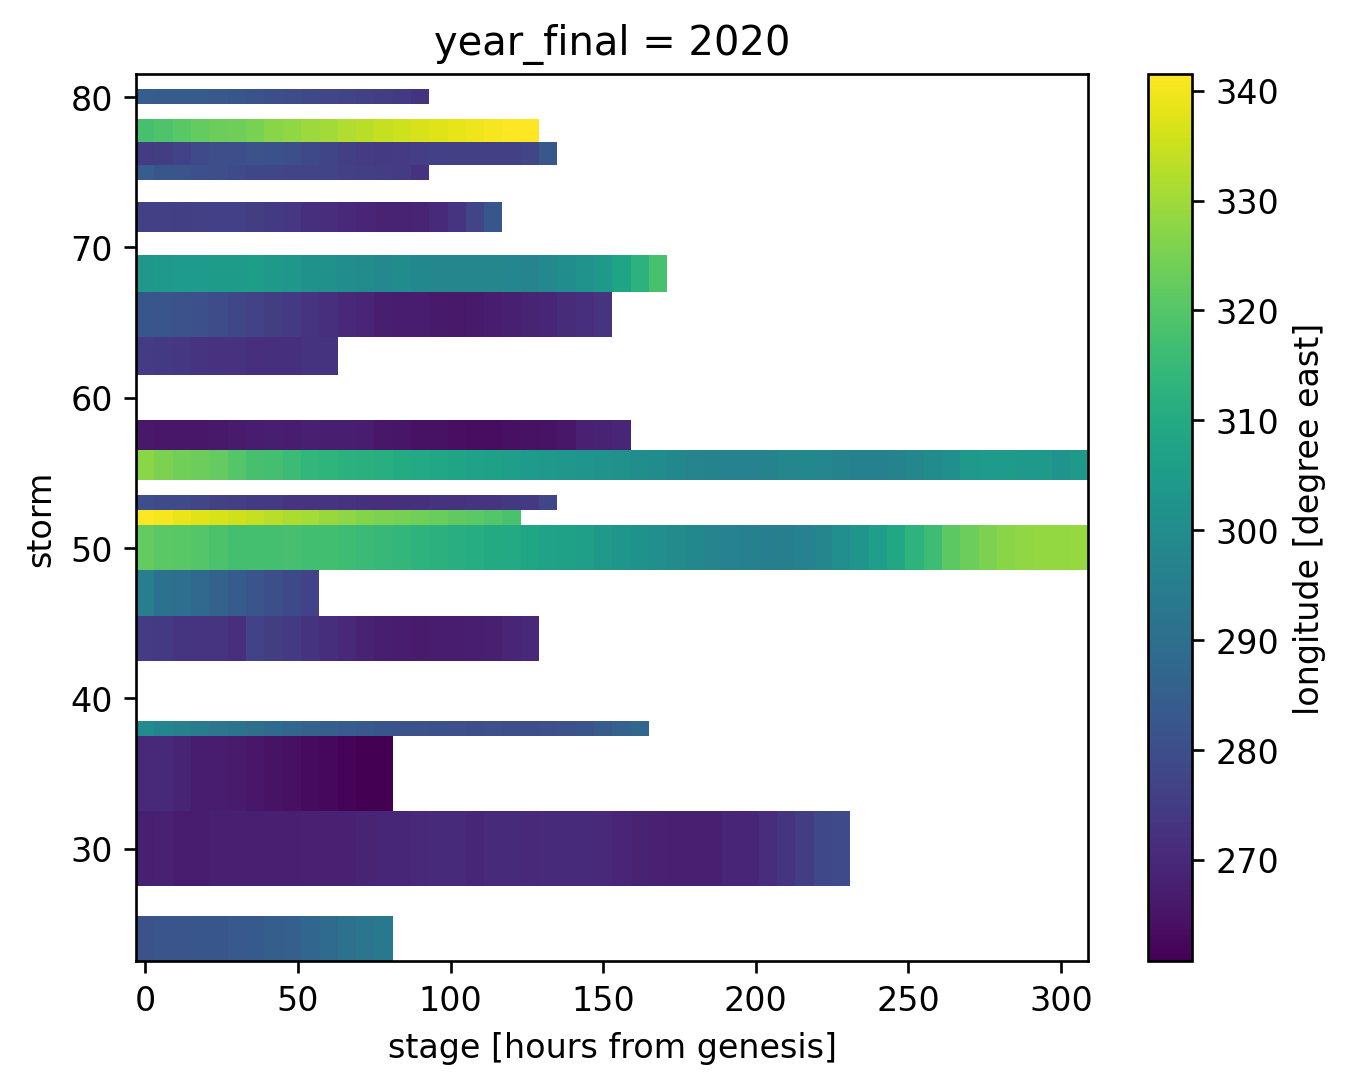

In [173]:
era5_atl.isel(year_final=0).lon.plot()

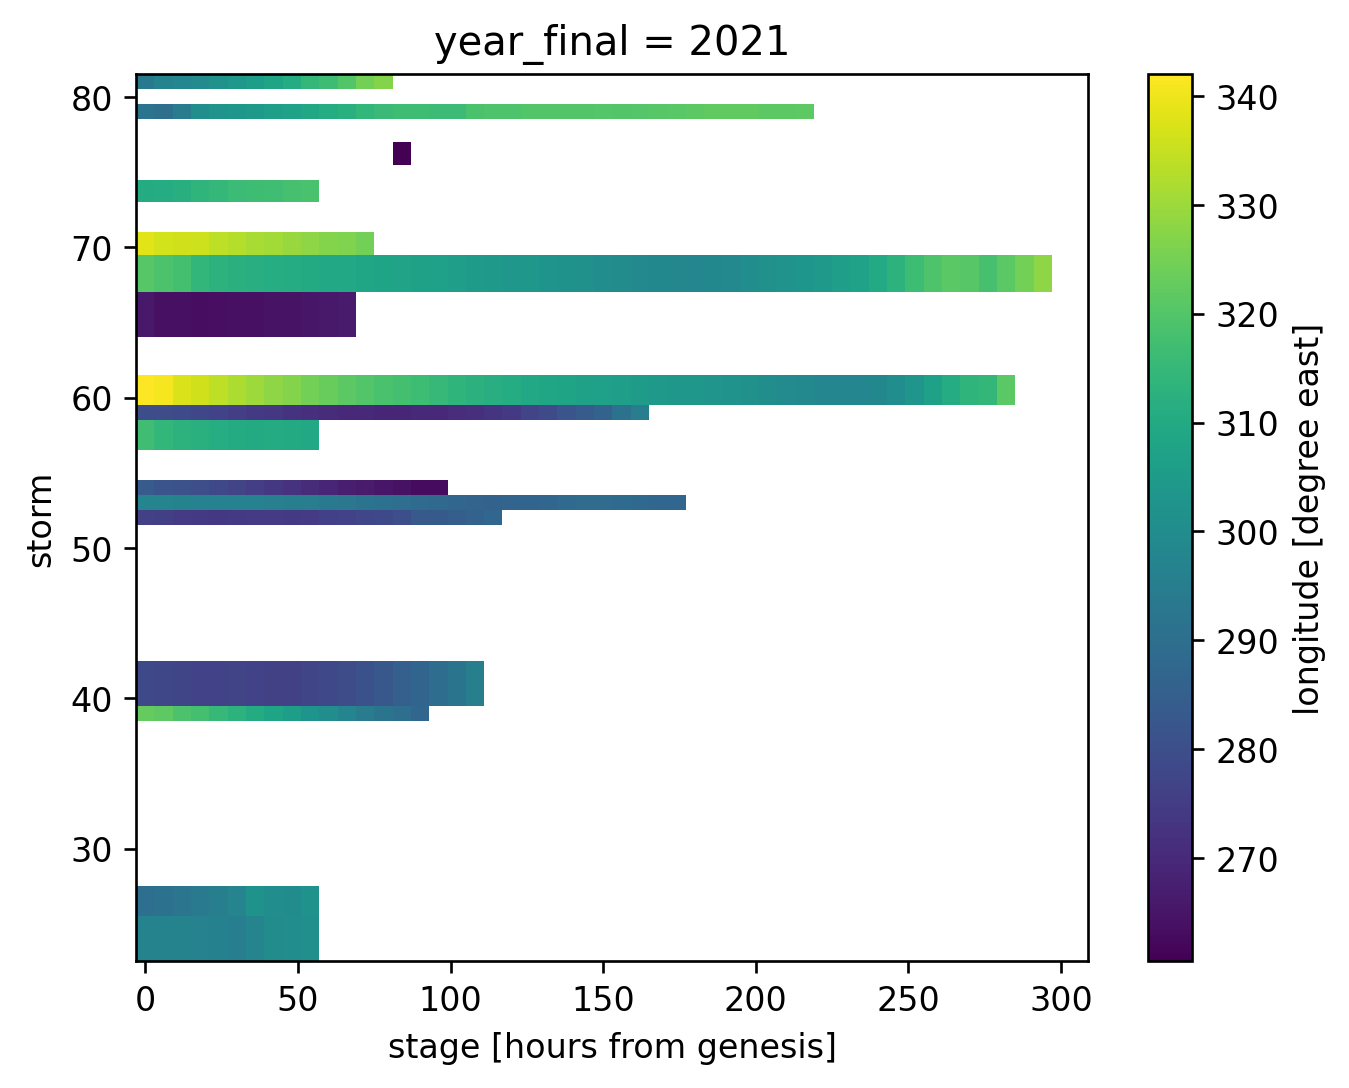

In [174]:
era5_atl.isel(year_final=1).lon.plot()

In [168]:
dloc = '/home/el2358/GEOCLIM/el2358/projects/tc_tracker/stitch_data_output'
years = [2021]

# Open and tag each dataset with its year
datasets = []
for year in years:
    ds = xr.open_dataset("{}/test{}.nc".format(dloc, year)).load()
    ds = ds.expand_dims(year_final=[year])  # Add 'year_final' dimension
    datasets.append(ds)

# Concatenate along the new 'year_final' dimension
era5 = xr.concat(datasets, dim="year_final")
era5_atl = era5.where(tracks_in_basin(era5, 'NA'), drop=True)

era5_atl.storm

/tmp/ipykernel_2515848/2854911565.py:49: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


<xarray.DataArray 'storm' (storm: 17)> Size: 136B
array([24, 27, 39, 40, 52, 53, 54, 58, 59, 60, 65, 69, 70, 74, 76, 79, 81])
Coordinates:
  * storm    (storm) int64 136B 24 27 39 40 52 53 54 58 ... 65 69 70 74 76 79 81

### Step 1) Uploading data

1. Getting 2018-2024 TCs from ERA5 tracked data
2. Getting 2018-2024 from IBTrACs dataset: https://www.ncei.noaa.gov/data/international-best-track-archive-for-climate-stewardship-ibtracs/v04r01/access/netcdf/


In [196]:
dloc = '/home/el2358/GEOCLIM/el2358/projects/tc_tracker/stitch_data_output'

# ----- ERA5 data ---------


# List of years
years = [2020, 2021]

# Open and tag each dataset with its year
datasets = []
for year in years:
    ds = xr.open_dataset("{}/test{}.nc".format(dloc, year)).load()
    ds = ds.expand_dims(year_final=[year])  # Add 'year_final' dimension
    datasets.append(ds)

# Concatenate along the new 'year_final' dimension
era5 = xr.concat(datasets, dim="year_final")
era5_atl = era5.where(tracks_in_basin(era5, 'NA'), drop=True)

# ----- IBTrACS data ---------

dloc = '/home/el2358/GEOCLIM/el2358/projects/tc_tracker/AI_model_test'
ibtracs = xr.open_dataset("{}/IBTrACS.NA.v04r01.nc".format(dloc)).load()

# extract 2005 season
ibtracs_atl = ibtracs.where(
    (ibtracs.time >= np.datetime64('2021-01-01')) & 
    (ibtracs.time <= np.datetime64('2021-12-31')),
    drop=True
)

# ensure longitude coordinates align with the ERA5 data
ibtracs_atl['lon'] = ibtracs_atl['lon'] % 360
ibtracs_atl['lon'] = ibtracs_atl['lon'].where(ibtracs_atl['lon']>190, other=ibtracs_atl['lon']+360)
#ibtracs_2005 = ibtracs_2005.sortby('lon')  # Optional


/tmp/ipykernel_2515848/2854911565.py:49: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


In [201]:
ibtracs_atl.lo

<xarray.Dataset> Size: 2MB
Dimensions:           (storm: 21, date_time: 117, quadrant: 4)
Coordinates:
    time              (storm, date_time) datetime64[ns] 20kB 2021-05-20T00:00...
    lat               (storm, date_time) float32 10kB 30.3 30.9 31.5 ... nan nan
    lon               (storm, date_time) float32 10kB 304.5 304.9 ... nan nan
Dimensions without coordinates: storm, date_time, quadrant
Data variables: (12/159)
    numobs            (storm, date_time) float32 10kB 33.0 33.0 33.0 ... nan nan
    sid               (storm, date_time) object 20kB b'2021140N30305' ... nan
    season            (storm, date_time) float32 10kB 2.021e+03 ... nan
    number            (storm, date_time) float32 10kB 31.0 31.0 31.0 ... nan nan
    basin             (storm, date_time) object 20kB b'NA' b'NA' ... nan nan
    subbasin          (storm, date_time) object 20kB b'NA' b'NA' ... nan nan
    ...                ...
    reunion_gust      (storm, date_time) float32 10kB nan nan nan ... nan nan
    reunion_gust_per  (storm, date_time) float32 10kB nan nan nan ... nan nan
    usa_seahgt        (storm, date_time) float32 10kB nan nan nan ... nan nan
    usa_searad        (storm, date_time, quadrant) float32 39kB nan nan ... nan
    storm_speed       (storm, date_time) float32 10kB 13.0 15.0 19.0 ... nan nan
    storm_dir         (storm, date_time) float32 10kB 30.0 35.0 40.0 ... nan nan
Attributes: (12/49)
    title:                      IBTrACS - International Best Track Archive fo...
    summary:                    The intent of the IBTrACS project is to overc...
    source:                     The original data are tropical cyclone positi...
    Conventions:                ACDD-1.3
    Conventions_note:           Data are nearly CF-1.7 compliant. The sole is...
    product_version:            v04r01
    ...                         ...
    history:                    Tue May  6 06:01:59 2025: ncks --no_abc --cnk...
    license:                    These data may be redistributed and used with...
    featureType:                trajectory
    cdm_data_type:              Trajectory
    comment:                    The tracks of TCs generally look like a traje...
    NCO:                        netCDF Operators version 5.0.7 (Homepage = ht...

### Step 2) determining where the ERA5 and IBTrACS TC tracks align to compute errors

Next we visually and quantitatively inspect where there false positives (where ERA5 detects a storm while IBTrACs does not) and false negatives occur (where IBTrACS detects a storm while ERA5 does not). We remove all of these, so that we are only comparing storms that both datasets believe to have existed. This is following the convention of Lam et al. 2023 for the analysis of the GraphCast model.

We consider IBTrACS as ground truth here. 

In [117]:
# number of storms each dataset detects
print('#TCs {} ERA5: {}'.format(y, len(era5_atl.storm)))

print('#TCs {} IBTrACS: {}'.format(y, len(ibtracs_atl.storm)))

#TCs 2020 ERA5: 29
#TCs 2020 IBTrACS: 52


/tmp/ipykernel_2515848/2854911565.py:49: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


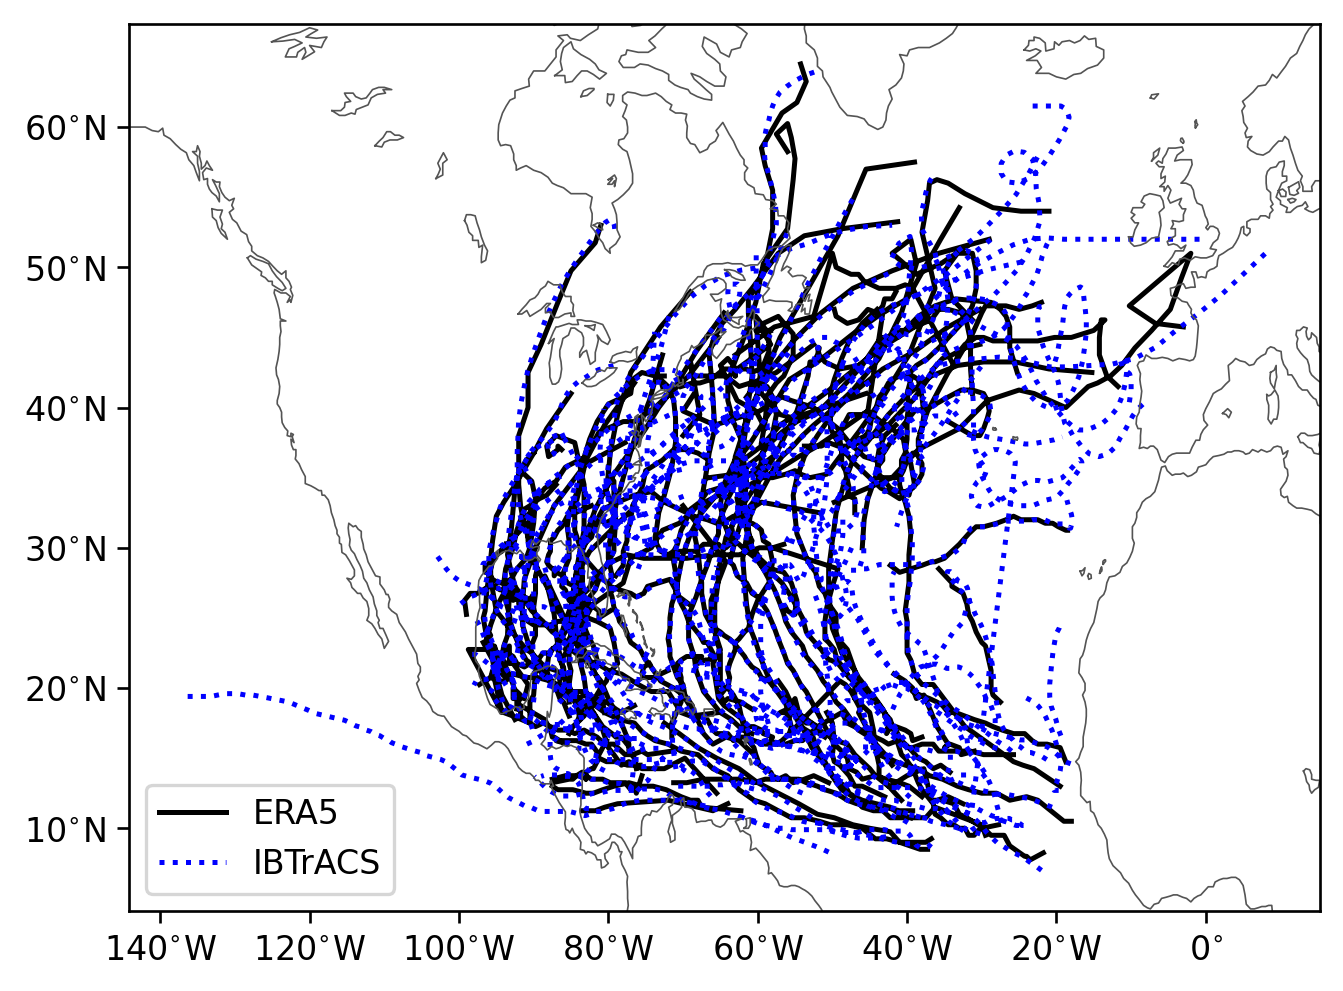

In [67]:
# plot raw 2005 tracks from both datasets

plt.plot(era5.where(tracks_in_basin(era5, 'NA')).lon.values.flat, 
         era5.where(tracks_in_basin(era5, 'NA')).lat.values.flat, color='k', label='ERA5')

plt.plot(ibtracs_atl.lon.values.flat,
         ibtracs_atl.lat.values.flat, color='b', linestyle=':', label='IBTrACS')

mapplot()
plt.legend()
plt.show()

Now we want to filter out only the storms where both datasets believe that have existed in some capacity. We will also calculate the false positive and false negative rate to understand where there were discrepencies in the datasets. 

To find storms that align across both datasets we will look timestep by timestep (6 hourly, since this is the resolution of the ERA5 data, whereas IBTRACs is 3 hourly). We will use the lower time resolution (6 hourly) for all timesteps.

For each timestep of the ERA5 data do the following:
Determine how many storms are in the basin at that particular time. 

To do:
1) loop through all values of time in ERA5
2) At each time determine how many TCs are in the basin
3) For each TC draw a 500 km radius around the storm
4) At that time determine if any IBTrACS storm lies within the radius
5) If it does record the lat, lon, windspeed, SLP for both models and the storm id for both models

6) determine hit/miss ratios for each season



In [130]:
# stack ERA5 data to be able to loop through all timesteps

era5_time = pd.to_datetime(dict(
    year=era5_2005_atl.year.values.ravel(),
    month=era5_2005_atl.month.values.ravel(),
    day=era5_2005_atl.day.values.ravel(),
    hour=era5_2005_atl.hour.values.ravel()
))
era5_stacked = era5_2005_atl.stack(timestep=('storm', 'stage'))
era5_stacked['time'] = (('timestep',), era5_time)

# Round time coordinates to the nearest hour (so they are consistent with each other)
# IBtracs rounds to further decimals than era5
ibtracs_2005['time'] = ibtracs_2005['time'].dt.round('H')
era5_stacked['time'] = era5_stacked['time'].dt.round('H')


/home/GEOCLIM/software/anaconda3/2024.10/envs/geoclim/lib/python3.10/site-packages/xarray/core/accessor_dt.py:163: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  field_values = method(freq=freq).values
/home/GEOCLIM/software/anaconda3/2024.10/envs/geoclim/lib/python3.10/site-packages/xarray/core/accessor_dt.py:163: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  field_values = method(freq=freq).values


In [54]:
def match(model, ibtracs):
    # Stack all 3 dimensions: year_final, storm, and stage
    model_stacked = model.stack(timestep=('year_final', 'storm', 'stage'))
    
    # Build time array from the same full shape
    model_time = pd.to_datetime(dict(
        year=model.year.values.ravel(),
        month=model.month.values.ravel(),
        day=model.day.values.ravel(),
        hour=model.hour.values.ravel()
    ))
    
    # Assign time coordinate
    model_stacked['time'] = (('timestep',), model_time)
    
    # Round time coordinates to the nearest hour (so they are consistent with each other)
    # IBtracs rounds to further decimals than era5
    ibtracs['time'] = ibtracs['time'].dt.round('H')
    model_stacked['time'] = model_stacked['time'].dt.round('H')

        # Get all unique time steps in ERA5
    unique_times = np.unique(model_stacked.time.values)
    
    matches = []
    
    # loop through all time steps 
    for t in unique_times:
        # Get ERA5 storm positions at this time
        model_mask = (model_stacked.time == t) & \
                   (~np.isnan(model_stacked.lat)) & (~np.isnan(model_stacked.lon))
        model_lats = model_stacked.lat.values[model_mask]
        model_lons = model_stacked.lon.values[model_mask]
        model_stormids = model_stacked.storm.values[model_mask]
    
        # Get IBTrACS storm positions at this time
        ib_mask = (ibtracs.time == t) & \
                  (~np.isnan(ibtracs.lat)) & (~np.isnan(ibtracs.lon))
        ib_lats = ibtracs.lat.values[ib_mask]
        ib_lons = ibtracs.lon.values[ib_mask]
        ib_stormids = ibtracs.number.values[ib_mask]
    
        # determine if IBTrACS storms lie within distance threshold of ERA%
        # use distance threshold of 500 km (somewhat arbitrary but 2x max track distance error for GraphCast model)
        for i, (mlat, mlon, mid) in enumerate(zip(model_lats, model_lons, model_stormids)):
            for j, (ilat, ilon, iid) in enumerate(zip(ib_lats, ib_lons, ib_stormids)):
                dist_km = haversine(mlat, mlon, ilat, ilon)
                if dist_km <= 500:
                    matches.append({
                        'time': t,
                        'model_lat': mlat,
                        'model_lon': mlon,
                        'ibtracs_lat': ilat,
                        'ibtracs_lon': ilon,
                        'model_stormid': mid,
                        'ibtracs_stormid': iid,
                    })

    df = pd.DataFrame(matches)
    # Ensure time is datetime64
    df['time'] = pd.to_datetime(df['time'])

    # Set time as index and convert to xarray
    ds = df.set_index('time').to_xarray()

    return ds


In [60]:
test = match(era5_atl, ibtracs_atl)

/home/GEOCLIM/software/anaconda3/2024.10/envs/geoclim/lib/python3.10/site-packages/xarray/core/accessor_dt.py:163: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  field_values = method(freq=freq).values
/home/GEOCLIM/software/anaconda3/2024.10/envs/geoclim/lib/python3.10/site-packages/xarray/core/accessor_dt.py:163: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  field_values = method(freq=freq).values


In [61]:
test

<xarray.Dataset> Size: 33kB
Dimensions:          (time: 746)
Coordinates:
  * time             (time) datetime64[ns] 6kB 2023-06-19T12:00:00 ... 2024-1...
Data variables:
    model_lat        (time) float64 6kB 11.25 11.25 11.75 ... 16.5 17.0 17.75
    model_lon        (time) float64 6kB 320.8 319.0 315.0 ... 272.5 272.2 271.5
    ibtracs_lat      (time) float32 3kB 10.9 11.1 11.5 11.7 ... 16.5 16.8 17.4
    ibtracs_lon      (time) float32 3kB 320.9 319.1 315.5 ... 272.5 272.1 270.9
    model_stormid    (time) int64 6kB 30 30 30 30 30 30 30 ... 74 74 74 74 74 74
    ibtracs_stormid  (time) float32 3kB 25.0 25.0 25.0 25.0 ... 87.0 87.0 87.0

In [63]:
era5_match_ids = test.model_stormid.values
era5_match_ids = np.unique(era5_match_ids)

ibtracs_match_ids = test.ibtracs_stormid.values
ibtracs_match_ids = np.unique(ibtracs_match_ids)

len(ibtracs_match_ids)



23

/tmp/ipykernel_2515848/2854911565.py:49: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


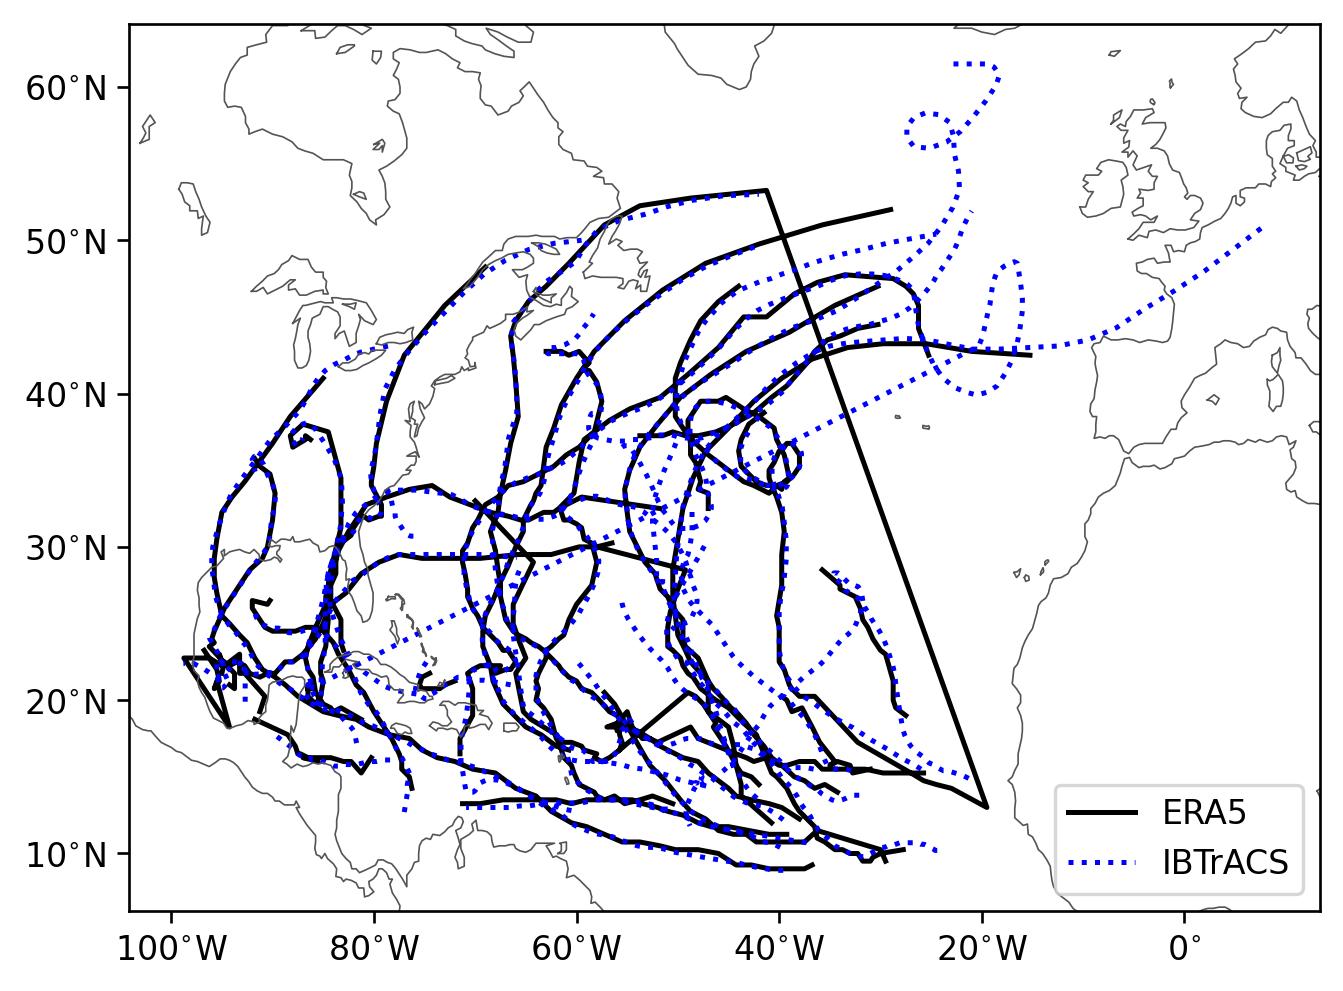

In [64]:
i_new = ibtracs_atl.where(ibtracs_atl.number.isin(ibtracs_match_ids), drop=True)
e_new = era5_atl.where(era5_atl.storm.isin(era5_match_ids), drop=True)



# plot raw 2005 tracks from both datasets

plt.plot(e_new.where(tracks_in_basin(e_new, 'NA')).lon.values.flat, 
         e_new.where(tracks_in_basin(e_new, 'NA')).lat.values.flat, color='k', label='ERA5')

plt.plot(i_new.lon.values.flat,
         i_new.lat.values.flat, color='b', linestyle=':', label='IBTrACS')

mapplot()
plt.legend()
plt.show()


In [47]:
# Stack all 3 dimensions: year_final, storm, and stage
era5_stacked = era5_atl.stack(timestep=('year_final', 'storm', 'stage'))

# Build time array from the same full shape
era5_time = pd.to_datetime(dict(
    year=era5_atl.year.values.ravel(),
    month=era5_atl.month.values.ravel(),
    day=era5_atl.day.values.ravel(),
    hour=era5_atl.hour.values.ravel()
))

# Assign time coordinate
era5_stacked['time'] = (('timestep',), era5_time)

# Round time coordinates to the nearest hour (so they are consistent with each other)
# IBtracs rounds to further decimals than era5
ibtracs_atl['time'] = ibtracs_atl['time'].dt.round('H')
era5_stacked['time'] = era5_stacked['time'].dt.round('H')

/home/GEOCLIM/software/anaconda3/2024.10/envs/geoclim/lib/python3.10/site-packages/xarray/core/accessor_dt.py:163: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  field_values = method(freq=freq).values
/home/GEOCLIM/software/anaconda3/2024.10/envs/geoclim/lib/python3.10/site-packages/xarray/core/accessor_dt.py:163: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  field_values = method(freq=freq).values


In [48]:
# Get all unique time steps in ERA5
unique_times = np.unique(era5_stacked.time.values)

matches = []

# loop through all time steps 
for t in unique_times:
    # Get ERA5 storm positions at this time
    era_mask = (era5_stacked.time == t) & \
               (~np.isnan(era5_stacked.lat)) & (~np.isnan(era5_stacked.lon))
    era_lats = era5_stacked.lat.values[era_mask]
    era_lons = era5_stacked.lon.values[era_mask]
    era_stormids = era5_stacked.storm.values[era_mask]

    # Get IBTrACS storm positions at this time
    ib_mask = (ibtracs_atl.time == t) & \
              (~np.isnan(ibtracs_atl.lat)) & (~np.isnan(ibtracs_atl.lon))
    ib_lats = ibtracs_atl.lat.values[ib_mask]
    ib_lons = ibtracs_atl.lon.values[ib_mask]
    ib_stormids = ibtracs_atl.number.values[ib_mask]

    # determine if IBTrACS storms lie within distance threshold of ERA%
    # use distance threshold of 500 km (somewhat arbitrary but 2x max track distance error for GraphCast model)
    for i, (elat, elon, eid) in enumerate(zip(era_lats, era_lons, era_stormids)):
        for j, (ilat, ilon, iid) in enumerate(zip(ib_lats, ib_lons, ib_stormids)):
            dist_km = haversine(elat, elon, ilat, ilon)
            if dist_km <= 500:
                matches.append({
                    'time': t,
                    'era5_lat': elat,
                    'era5_lon': elon,
                    'ibtracs_lat': ilat,
                    'ibtracs_lon': ilon,
                    'era5_stormid': eid,
                    'ibtracs_stormid': iid,
                })

    

In [49]:
ds

<xarray.Dataset> Size: 103kB
Dimensions:          (time: 2349)
Coordinates:
  * time             (time) datetime64[ns] 19kB 2018-05-26T18:00:00 ... 2024-...
Data variables:
    era5_lat         (time) float64 19kB 23.5 24.0 25.25 ... 16.5 17.0 17.75
    era5_lon         (time) float64 19kB 276.0 274.8 276.5 ... 272.5 272.2 271.5
    ibtracs_lat      (time) float32 9kB 22.6 23.6 24.9 26.6 ... 16.5 16.8 17.4
    ibtracs_lon      (time) float32 9kB 274.7 275.2 275.7 ... 272.5 272.1 270.9
    era5_stormid     (time) int64 19kB 28 28 28 28 28 28 ... 74 74 74 74 74 74
    ibtracs_stormid  (time) float32 9kB 25.0 25.0 25.0 25.0 ... 87.0 87.0 87.0

In [35]:
# Convert to DataFrame
df = pd.DataFrame(matches)
# Ensure time is datetime64
df['time'] = pd.to_datetime(df['time'])

# Set time as index and convert to xarray
ds = df.set_index('time').to_xarray()

In [50]:
era5_match_ids = ds.era5_stormid.values
era5_match_ids = np.unique(era5_match_ids)

ibtracs_match_ids = ds.ibtracs_stormid.values
ibtracs_match_ids = np.unique(ibtracs_match_ids)

In [51]:
len(ibtracs_match_ids)

55

In [39]:
i_new = ibtracs_atl.where(ibtracs_atl.number.isin(ibtracs_match_ids), drop=True)
e_new = era5_atl.where(era5_atl.storm.isin(era5_match_ids), drop=True)

/tmp/ipykernel_2515848/2854911565.py:49: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


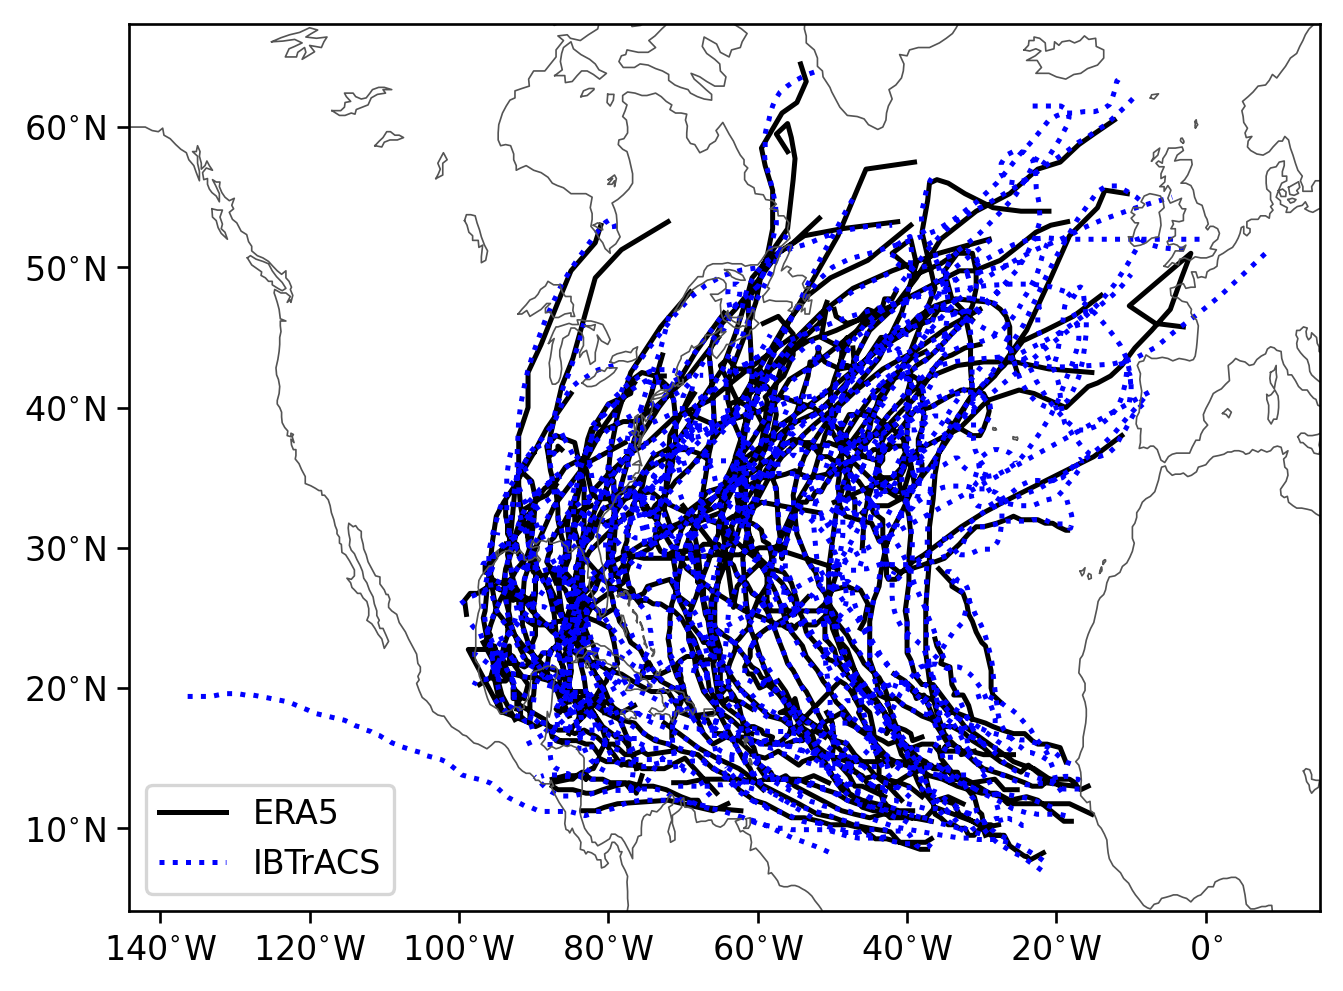

In [40]:


# plot raw 2005 tracks from both datasets

plt.plot(e_new.where(tracks_in_basin(e_new, 'NA')).lon.values.flat, 
         e_new.where(tracks_in_basin(e_new, 'NA')).lat.values.flat, color='k', label='ERA5')

plt.plot(i_new.lon.values.flat,
         i_new.lat.values.flat, color='b', linestyle=':', label='IBTrACS')

mapplot()
plt.legend()
plt.show()

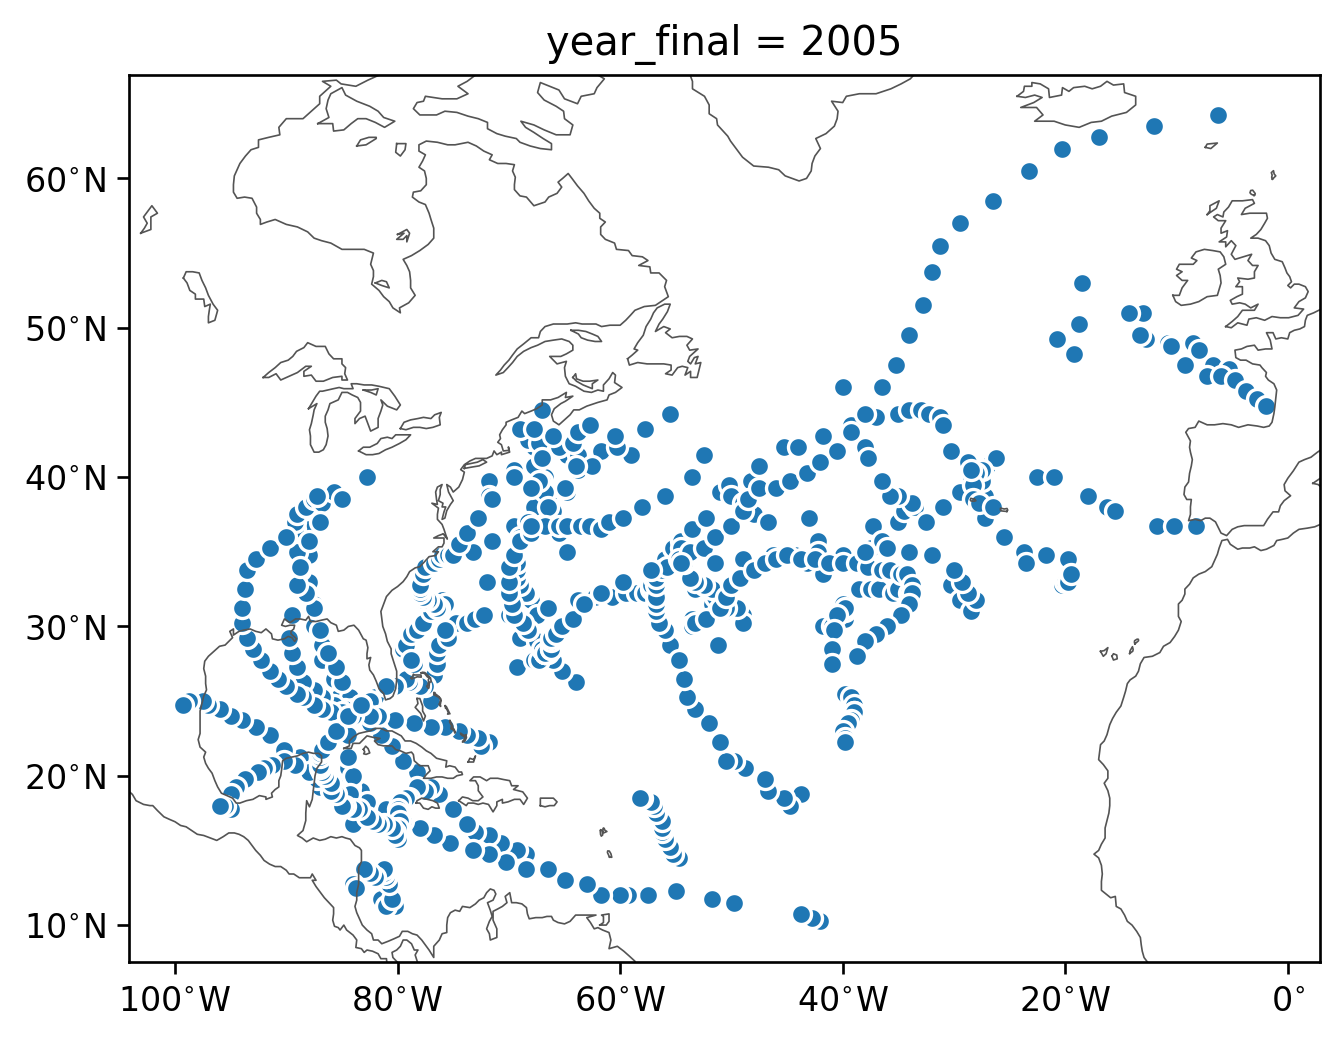

In [78]:
era5_2005_atl.plot.scatter(x='lon', y='lat')
mapplot()

In [52]:
era5_2004 = era5.sel(year_final=2004)

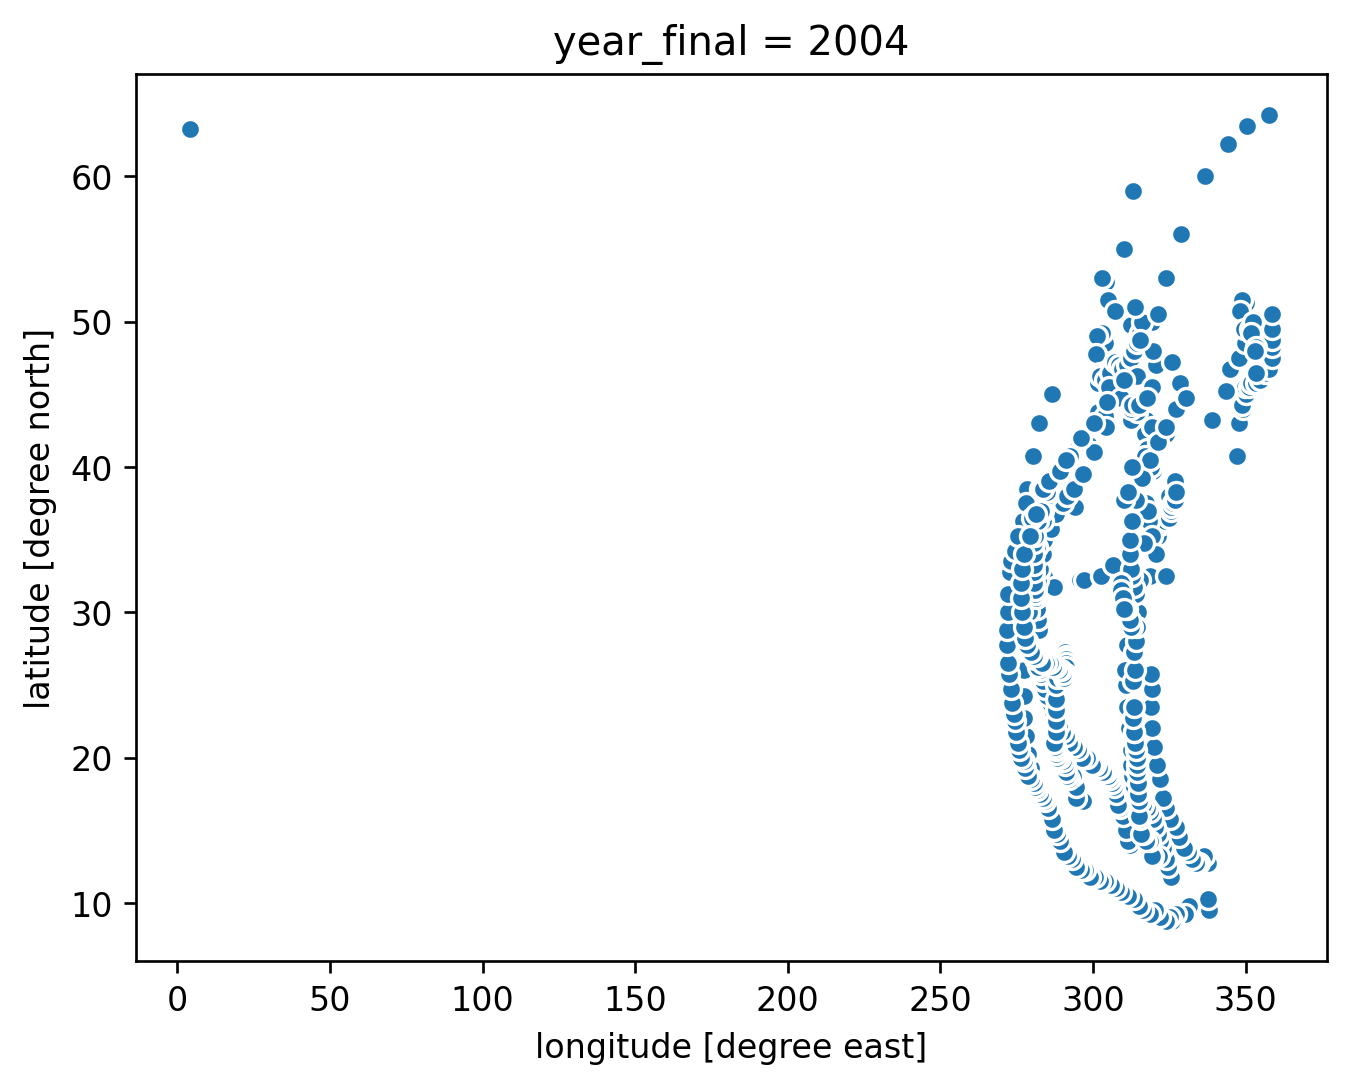

In [57]:
era5_2004.where(L).plot.scatter(x='lon', y='lat')

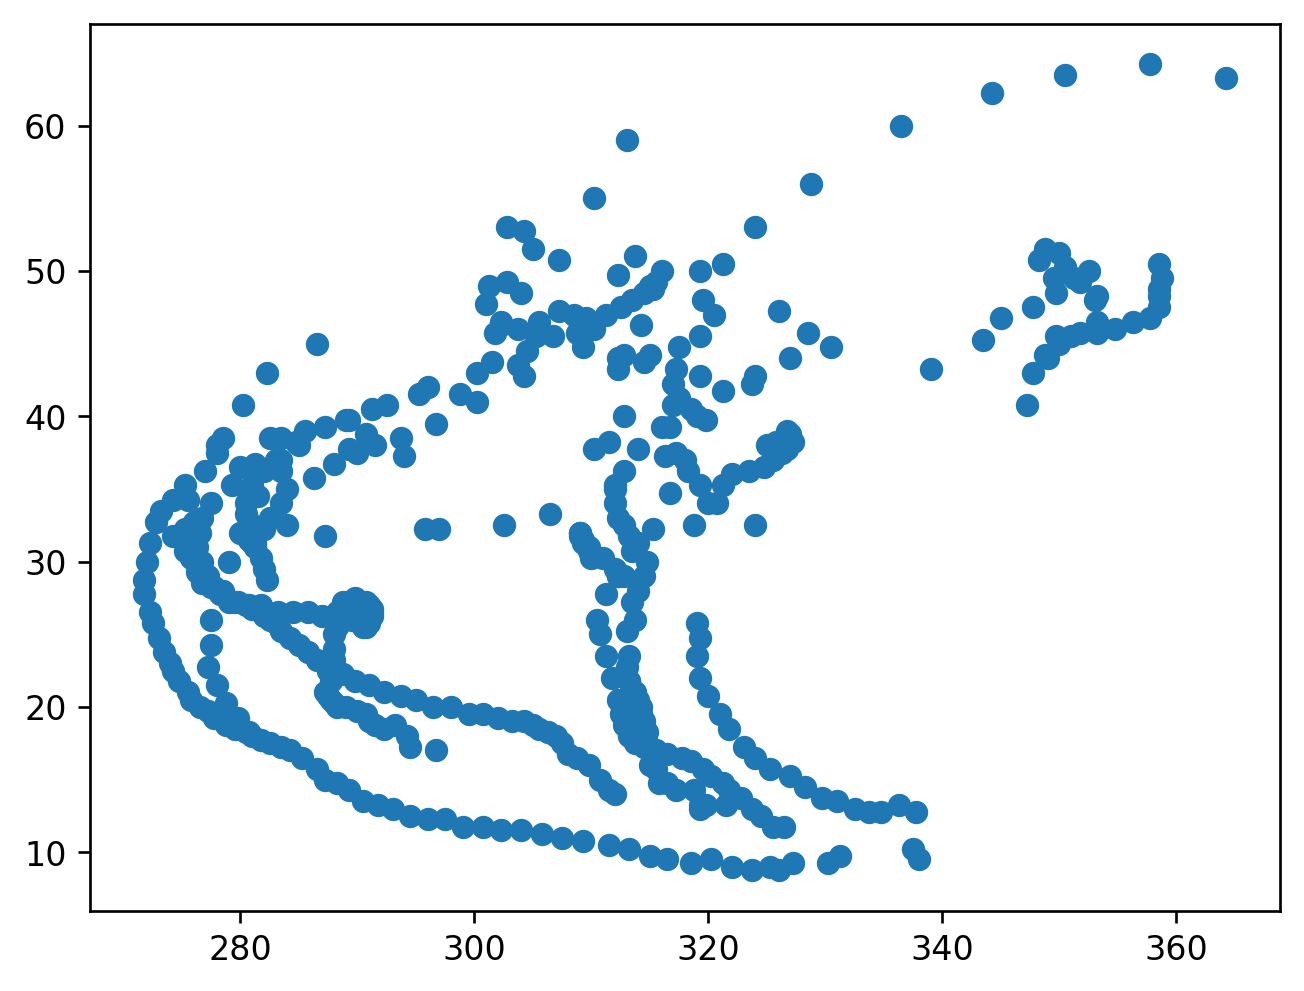

In [62]:
lon = era5_2004.where(L).lon
lat = era5_2004.where(L).lat
windmax = era5_2004.where(L).windmax
lon = lon.where(lon>180, other=lon+360)
plt.scatter(lon, lat)

In [63]:
ds_2004 = xr.Dataset(dict(lon=lon, lat=lat, windmax=windmax))

/tmp/ipykernel_2794537/347444826.py:51: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


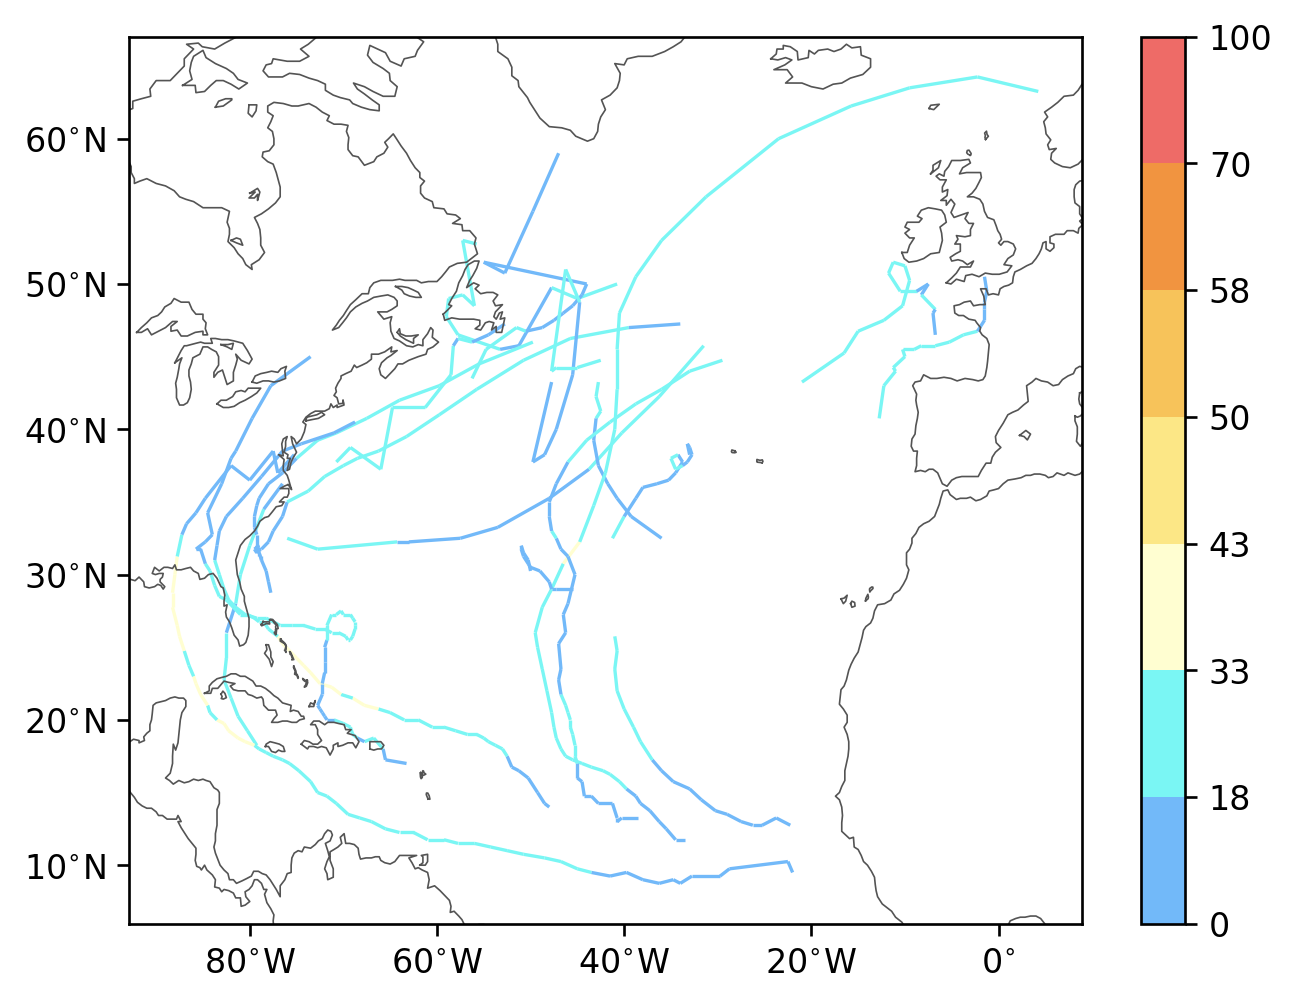

In [66]:
basin = 'NA'
L = ds_2004.isel(stage=0).pipe(tracks_in_basin, basin)
lines = ds_2004.where(L).pipe(trackplot)
mapplot()
plt.colorbar(lines.values[0])

In [65]:
lines

<xarray.DataArray (storm: 116)> Size: 928B
array([<matplotlib.collections.LineCollection object at 0x147fe1376860>,
       <matplotlib.collections.LineCollection object at 0x147fe1316fb0>,
       <matplotlib.collections.LineCollection object at 0x147fe13175b0>,
       <matplotlib.collections.LineCollection object at 0x147fe1317910>,
       <matplotlib.collections.LineCollection object at 0x147fe1317c70>,
       <matplotlib.collections.LineCollection object at 0x147fe1140250>,
       <matplotlib.collections.LineCollection object at 0x147fe1140580>,
       <matplotlib.collections.LineCollection object at 0x147fe11408e0>,
       <matplotlib.collections.LineCollection object at 0x147fe1140c40>,
       <matplotlib.collections.LineCollection object at 0x147fe1140fa0>,
       <matplotlib.collections.LineCollection object at 0x147fe1141300>,
       <matplotlib.collections.LineCollection object at 0x147fe1141660>,
       <matplotlib.collections.LineCollection object at 0x147fe11419c0>,
       <matplotlib.collections.LineCollection object at 0x147fe1141d20>,
       <matplotlib.collections.LineCollection object at 0x147fe1142290>,
       <matplotlib.collections.LineCollection object at 0x147fe11425c0>,
       <matplotlib.collections.LineCollection object at 0x147fe1142920>,
       <matplotlib.collections.LineCollection object at 0x147fe1142e90>,
       <matplotlib.collections.LineCollection object at 0x147fe11431c0>,
       <matplotlib.collections.LineCollection object at 0x147fe1143520>,
...
       <matplotlib.collections.LineCollection object at 0x147fe109cd00>,
       <matplotlib.collections.LineCollection object at 0x147fe109d060>,
       <matplotlib.collections.LineCollection object at 0x147fe109d3c0>,
       <matplotlib.collections.LineCollection object at 0x147fe109d720>,
       <matplotlib.collections.LineCollection object at 0x147fe109da80>,
       <matplotlib.collections.LineCollection object at 0x147fe109dde0>,
       <matplotlib.collections.LineCollection object at 0x147fe109e140>,
       <matplotlib.collections.LineCollection object at 0x147fe109e4a0>,
       <matplotlib.collections.LineCollection object at 0x147fe109e800>,
       <matplotlib.collections.LineCollection object at 0x147fe109eb60>,
       <matplotlib.collections.LineCollection object at 0x147fe109eec0>,
       <matplotlib.collections.LineCollection object at 0x147fe109f220>,
       <matplotlib.collections.LineCollection object at 0x147fe109f580>,
       <matplotlib.collections.LineCollection object at 0x147fe109f8e0>,
       <matplotlib.collections.LineCollection object at 0x147fe109fc40>,
       <matplotlib.collections.LineCollection object at 0x147fe109ffa0>,
       <matplotlib.collections.LineCollection object at 0x147fe10d4340>,
       <matplotlib.collections.LineCollection object at 0x147fe10d46a0>,
       <matplotlib.collections.LineCollection object at 0x147fe10d4a00>],
      dtype=object)
Coordinates:
  * storm       (storm) int64 928B 1 2 3 4 5 6 7 ... 110 111 112 113 114 115 116
    year_final  int64 8B 2004

In [42]:
era5_2005.plot(x='lon', y='lat')

ValueError: Dataset.plot cannot be called directly. Use an explicit plot method, e.g. ds.plot.scatter(...)

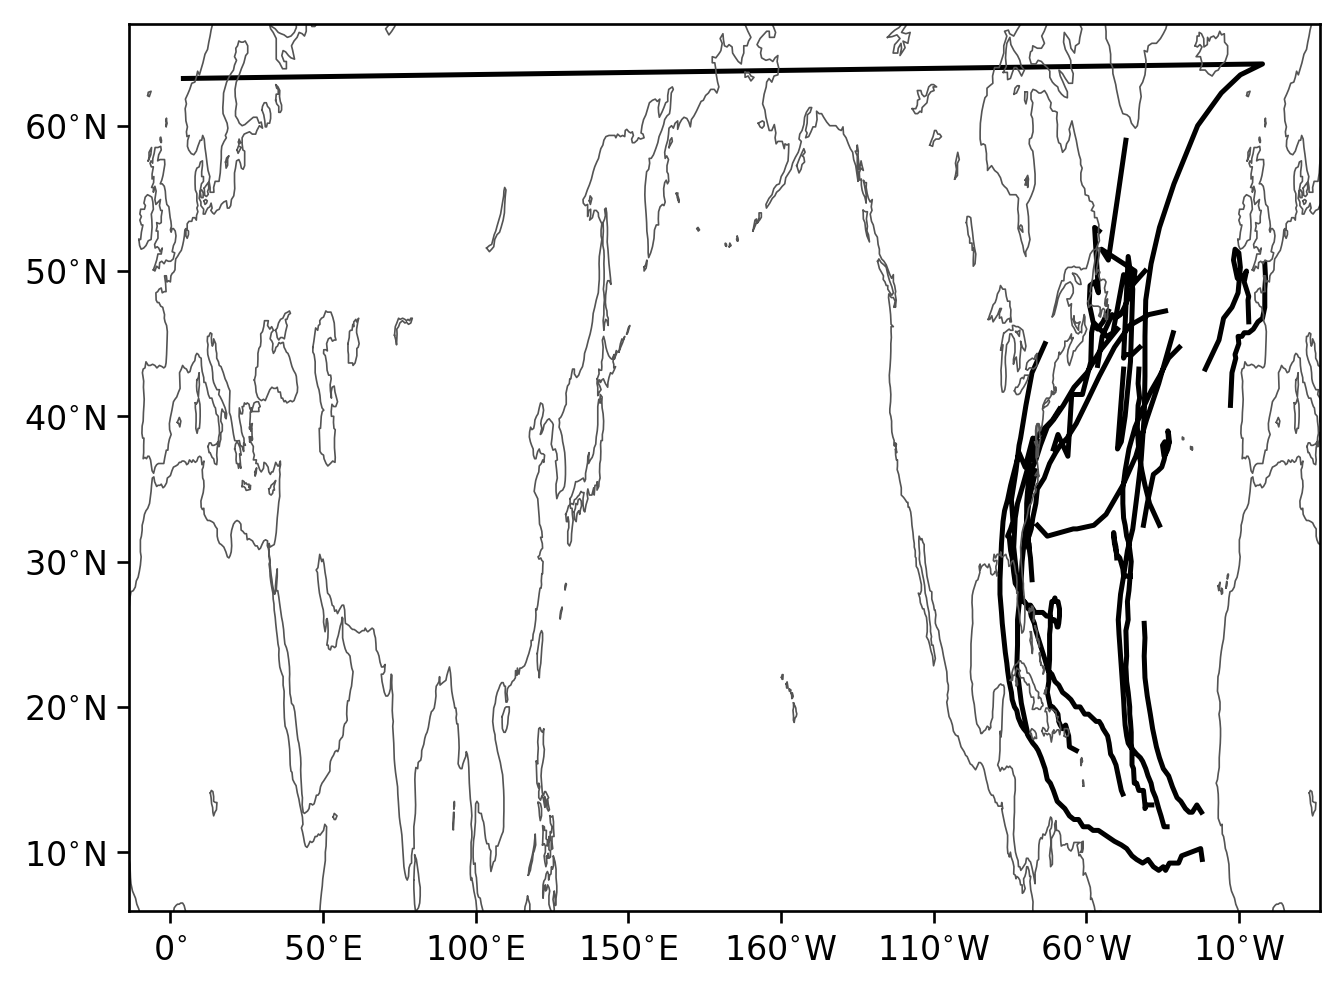

In [54]:
plt.plot(era5_2004.where(L).lon.values.flat, era5_2004.where(L).lat.values.flat, color='k')
mapplot()
plt.show()

In [30]:
lines.isel(year_final=0, storm=0).item()

In [32]:
lines.values[0,0]

In [18]:
plt.colorbar?

Signature:
plt.colorbar(
    mappable: 'ScalarMappable | None' = None,
    cax: 'matplotlib.axes.Axes | None' = None,
    ax: 'matplotlib.axes.Axes | Iterable[matplotlib.axes.Axes] | None' = None,
    **kwargs,
) -> 'Colorbar'
Docstring:
Add a colorbar to a plot.

Parameters
----------
mappable
    The `matplotlib.cm.ScalarMappable` (i.e., `.AxesImage`,
    `.ContourSet`, etc.) described by this colorbar.  This argument is
    mandatory for the `.Figure.colorbar` method but optional for the
    `.pyplot.colorbar` function, which sets the default to the current
    image.

    Note that one can create a `.ScalarMappable` "on-the-fly" to
    generate colorbars not attached to a previously drawn artist, e.g.
    ::

        fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax)

cax : `~matplotlib.axes.Axes`, optional
    Axes into which the colorbar will be drawn.  If `None`, then a new
    Axes is created and the space for it will be stolen from the Axes(s)
    specified in *ax*.


In [36]:
era5.pipe(trackplot, ezplot=True, lw=0.5, alpha=0.5)
mapplot()

TypeError: single_track_plot() got an unexpected keyword argument 'ezplot'

In [67]:
ace2

<xarray.Dataset> Size: 2MB
Dimensions:      (storm: 207, stage: 120)
Coordinates:
  * storm        (storm) int64 2kB 1 2 3 4 5 6 7 ... 201 202 203 204 205 206 207
  * stage        (stage) int64 960B 0 6 12 18 24 30 ... 684 690 696 702 708 714
Data variables:
    lat          (storm, stage) float64 199kB -10.47 -10.47 -9.474 ... nan nan
    lon          (storm, stage) float64 199kB 92.5 92.5 95.5 ... nan nan nan
    windmax      (storm, stage) float64 199kB 16.63 15.49 19.48 ... nan nan nan
    slp          (storm, stage) float64 199kB 1.005e+05 1.006e+05 ... nan nan
    hsfc         (storm, stage) float64 199kB -4.965 -4.965 -5.704 ... nan nan
    windmax_10m  (storm, stage) float64 199kB 12.56 11.95 13.56 ... nan nan nan
    year         (storm, stage) float64 199kB 2.002e+03 2.002e+03 ... nan nan
    month        (storm, stage) float64 199kB 1.0 1.0 1.0 1.0 ... nan nan nan
    day          (storm, stage) float64 199kB 1.0 1.0 2.0 3.0 ... nan nan nan
    hour         (storm, stage) float64 199kB 6.0 18.0 18.0 0.0 ... nan nan nan

/tmp/ipykernel_2794537/347444826.py:51: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


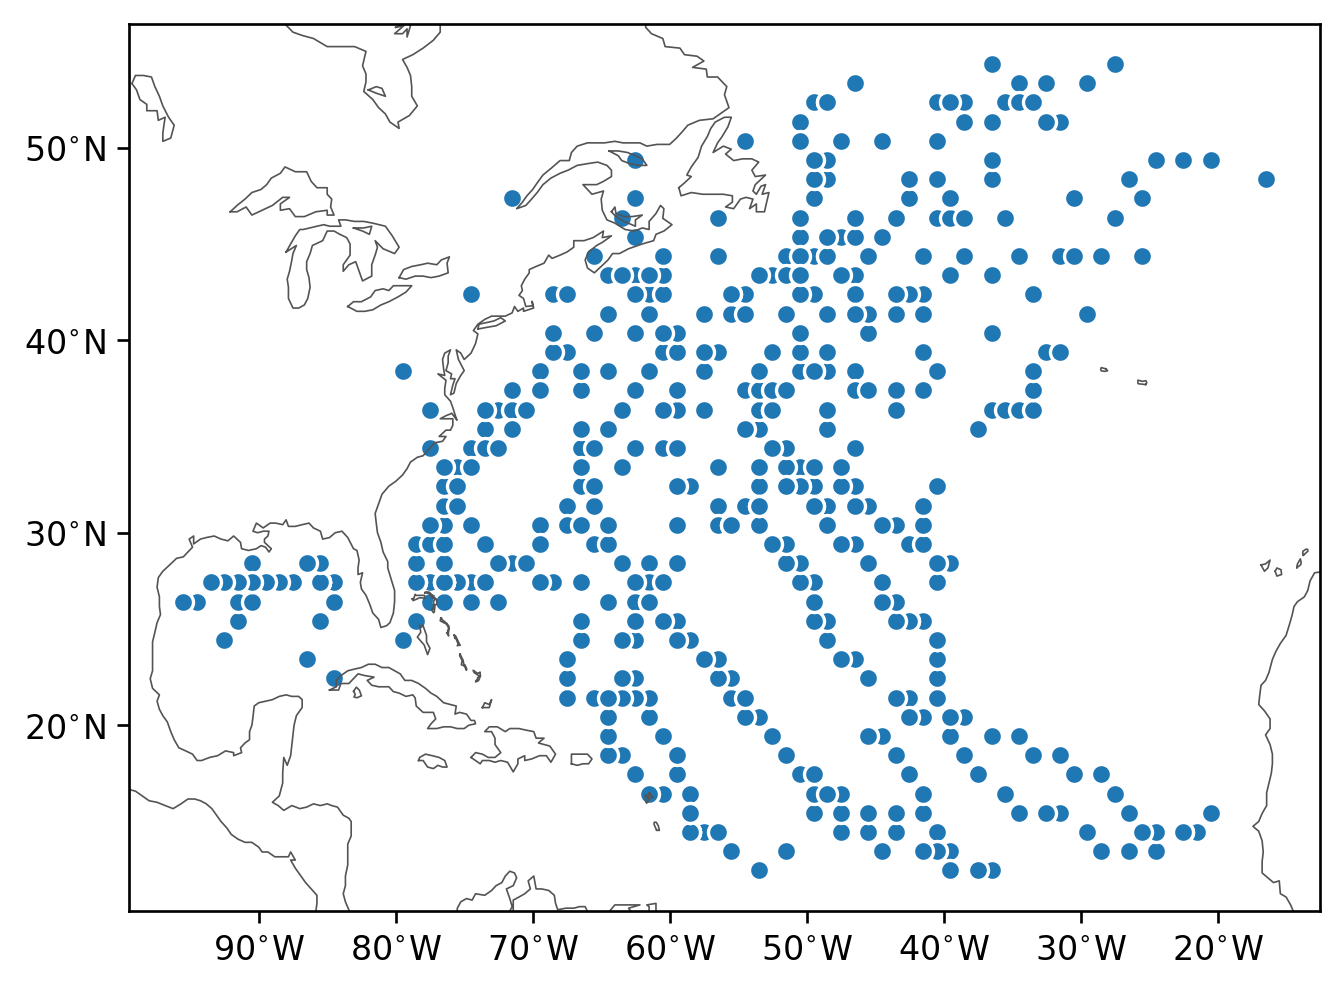

In [72]:
ace2.where(tracks_in_basin(ace2.isel(stage=0), 'NA')).plot.scatter(x='lon', y='lat')
mapplot()

In [80]:
ace2_2005 = ace2.where(ace2.year==2005)

In [75]:
ace2.where(year=2005)

TypeError: DataWithCoords.where() got an unexpected keyword argument 'year'

/tmp/ipykernel_2794537/347444826.py:51: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


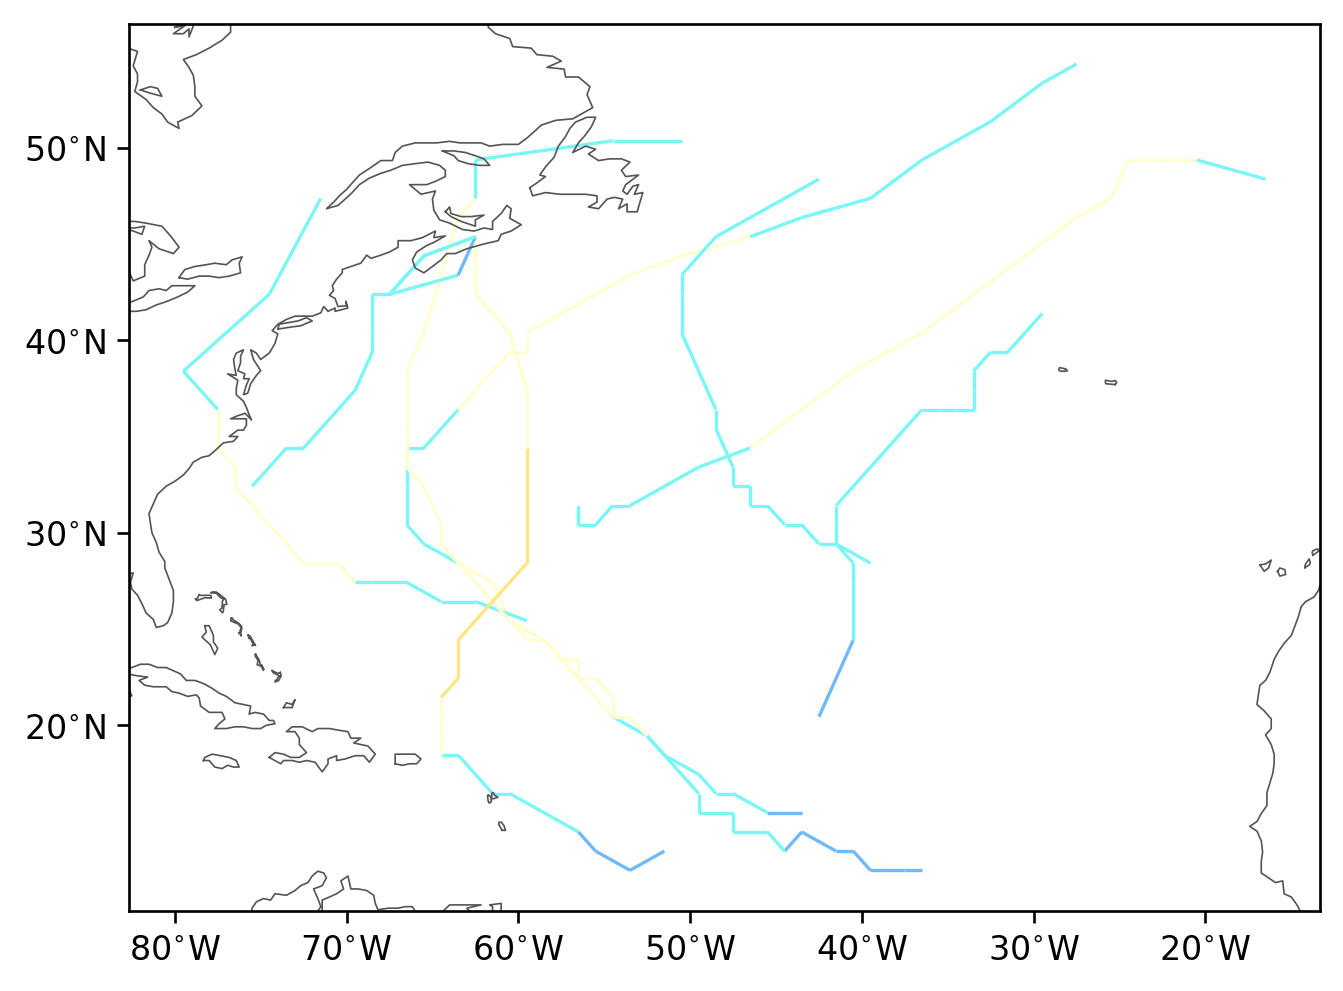

In [82]:
basin = 'NA'
L = tracks_in_basin(ace2_2005.isel(stage=0), 'NA')
ace2_2005.where(L).pipe(trackplot)
mapplot()

/tmp/ipykernel_2794537/347444826.py:51: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])
/tmp/ipykernel_2794537/347444826.py:51: FutureWarning: `Regions.coords` has been deprecated in v0.12.0 and will be removed. Please raise an issue if you have an use case for them.
  basin_domain = path.Path(basins.coords[basin_index])


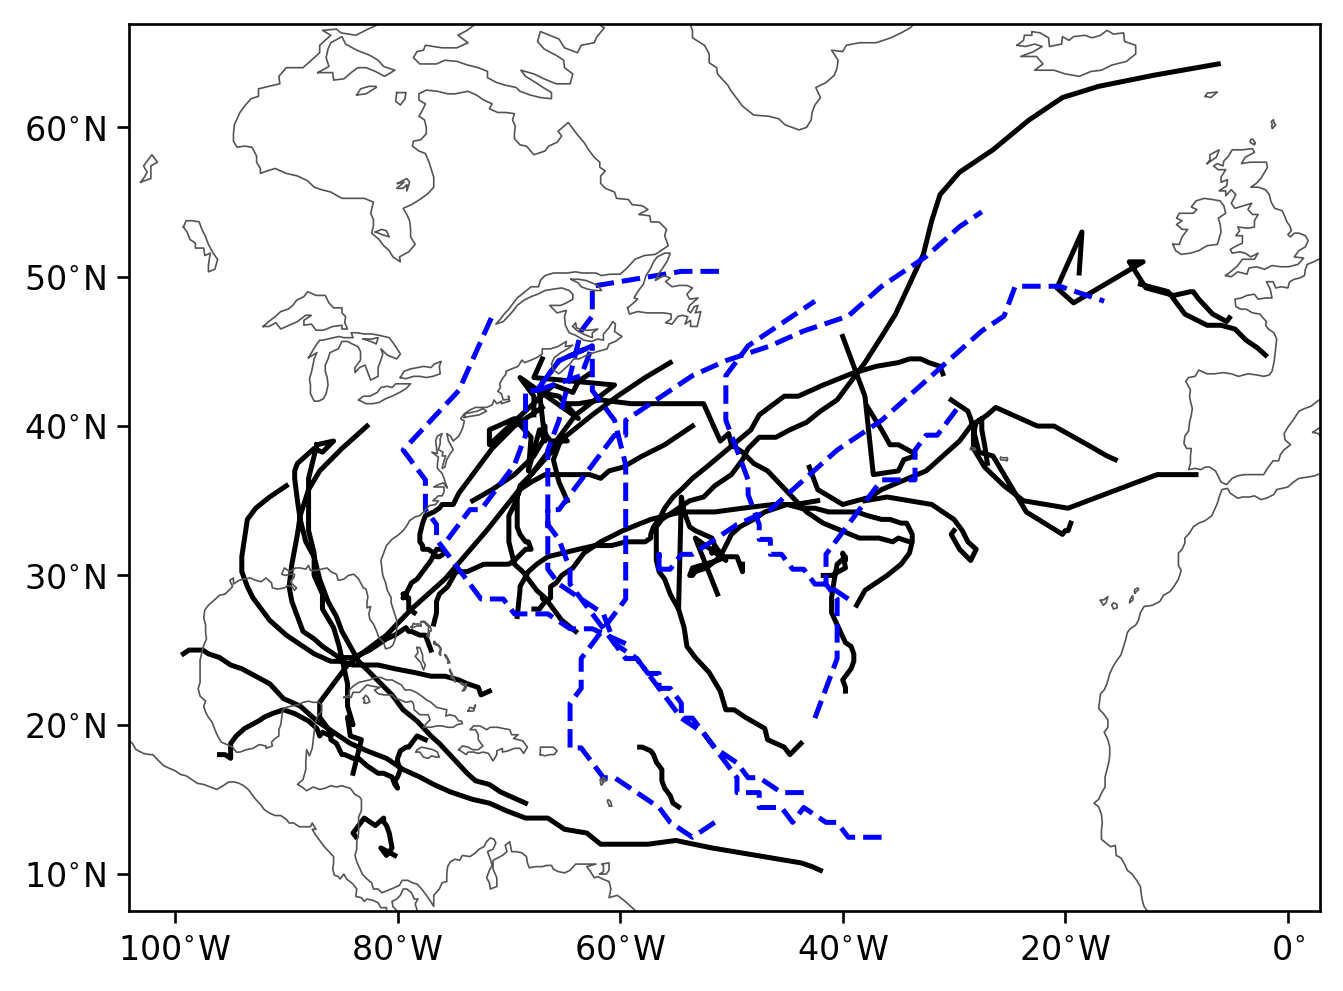

In [84]:
plt.plot(era5_2005.where(tracks_in_basin(era5_2005, 'NA')).lon.values.flat, era5_2005.where(tracks_in_basin(era5_2005, 'NA')).lat.values.flat, color='k')

plt.plot(ace2_2005.where(L).lon.values.flat, ace2_2005.where(L).lat.values.flat, color='b', linestyle='--')
mapplot()
plt.show()

In [18]:
era5.pipe(trackplot, ezplot=True, lw=0.5, alpha=0.5)
mapplot()

TypeError: single_track_plot() got an unexpected keyword argument 'ezplot'

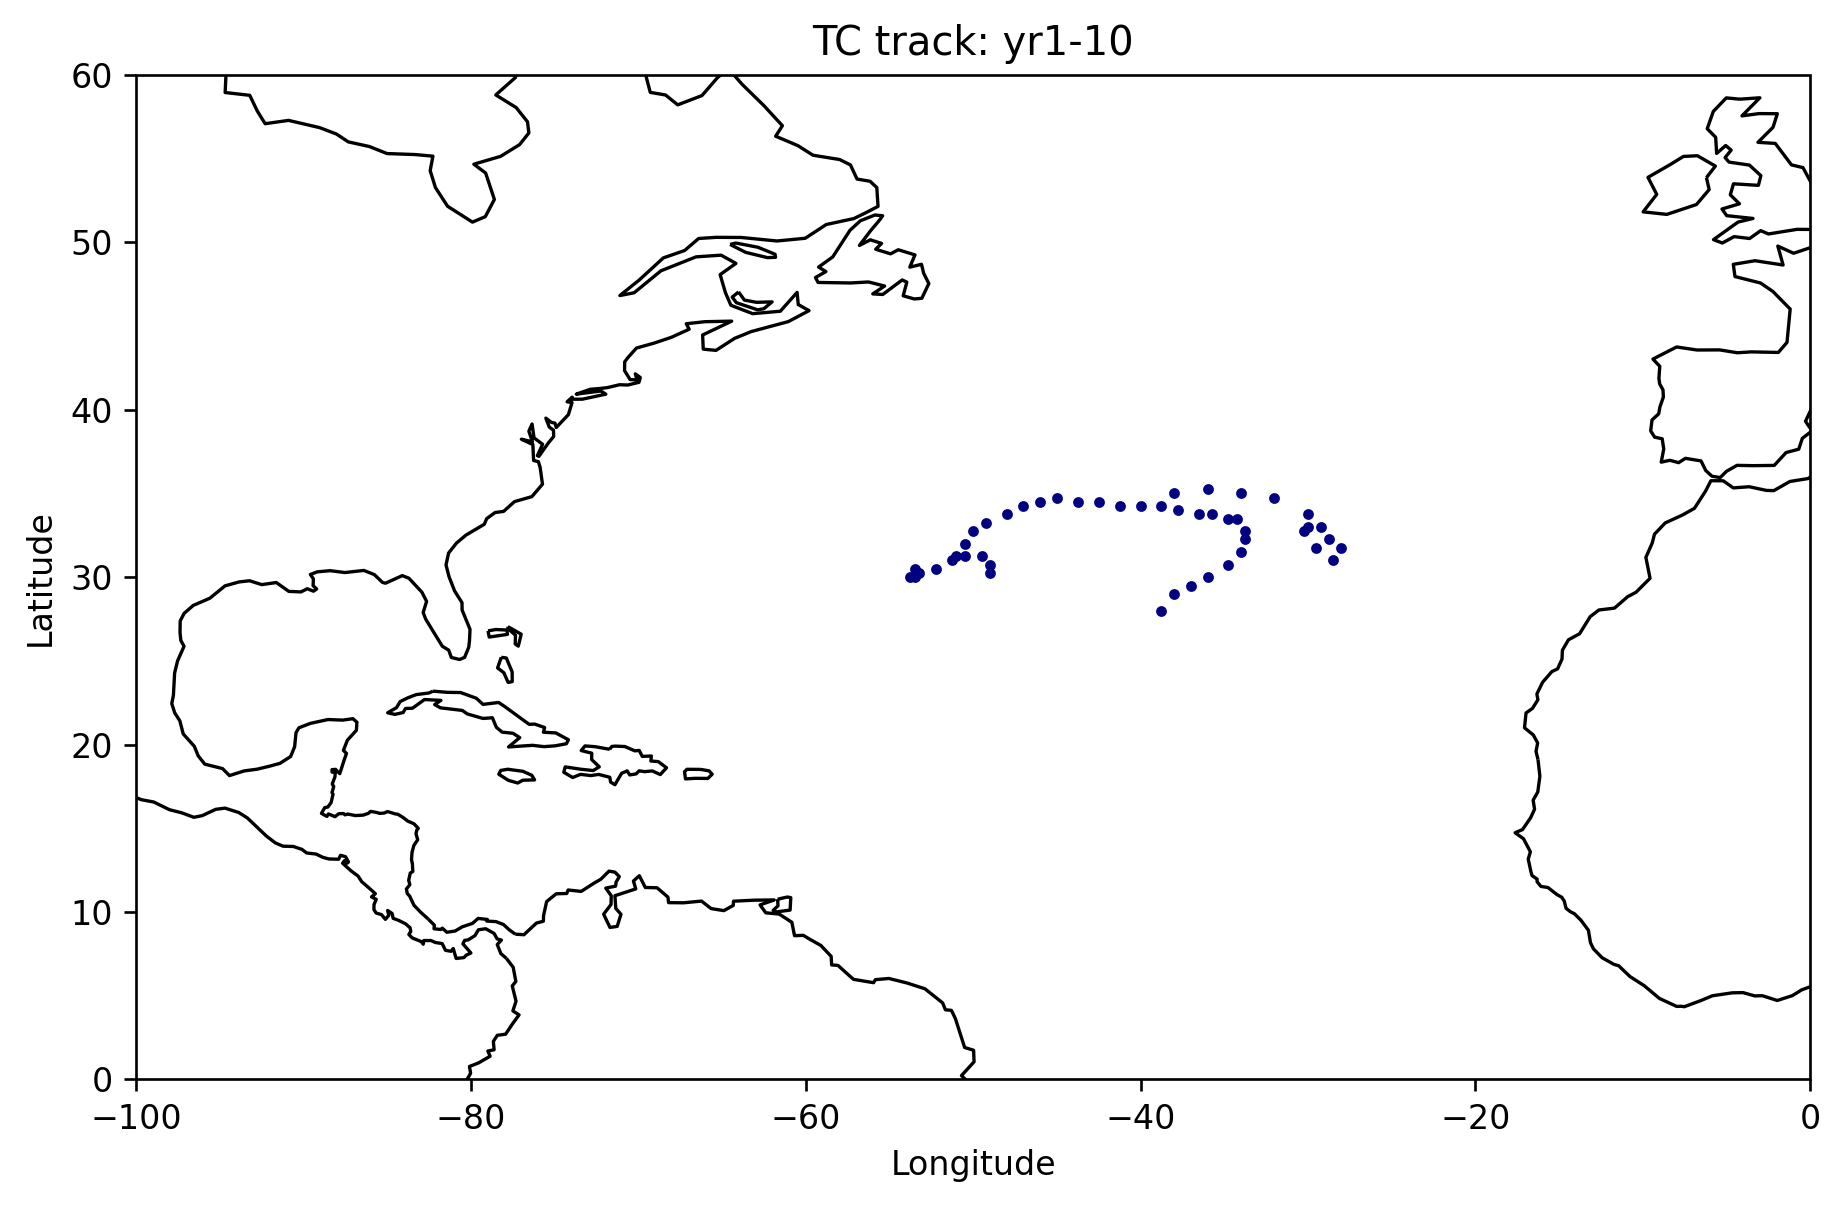

In [85]:
# Set up subplots with PlateCarree projection
year_mask = ace2.year.isin([2004, 2005])


# Apply mask to all variables — where the condition is False, values become NaN
ace2_2004_2005 = ds.where(year_mask, drop=False)  # drop=False keeps full shape with NaNs

fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(9, 8.5))

plt.scatter(ace2_2004_2005.lon, ace2_2004_2005.lat, color='navy', s=5, transform=ccrs.PlateCarree())

axes.coastlines()
axes.set_xticks(np.arange(-100, 20, 20), crs=ccrs.PlateCarree())
axes.set_yticks(np.arange(0, 61, 10), crs=ccrs.PlateCarree())
axes.set_extent([-100, 0, 0, 60], crs=ccrs.PlateCarree())

plt.title('TC track: yr1-10')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()


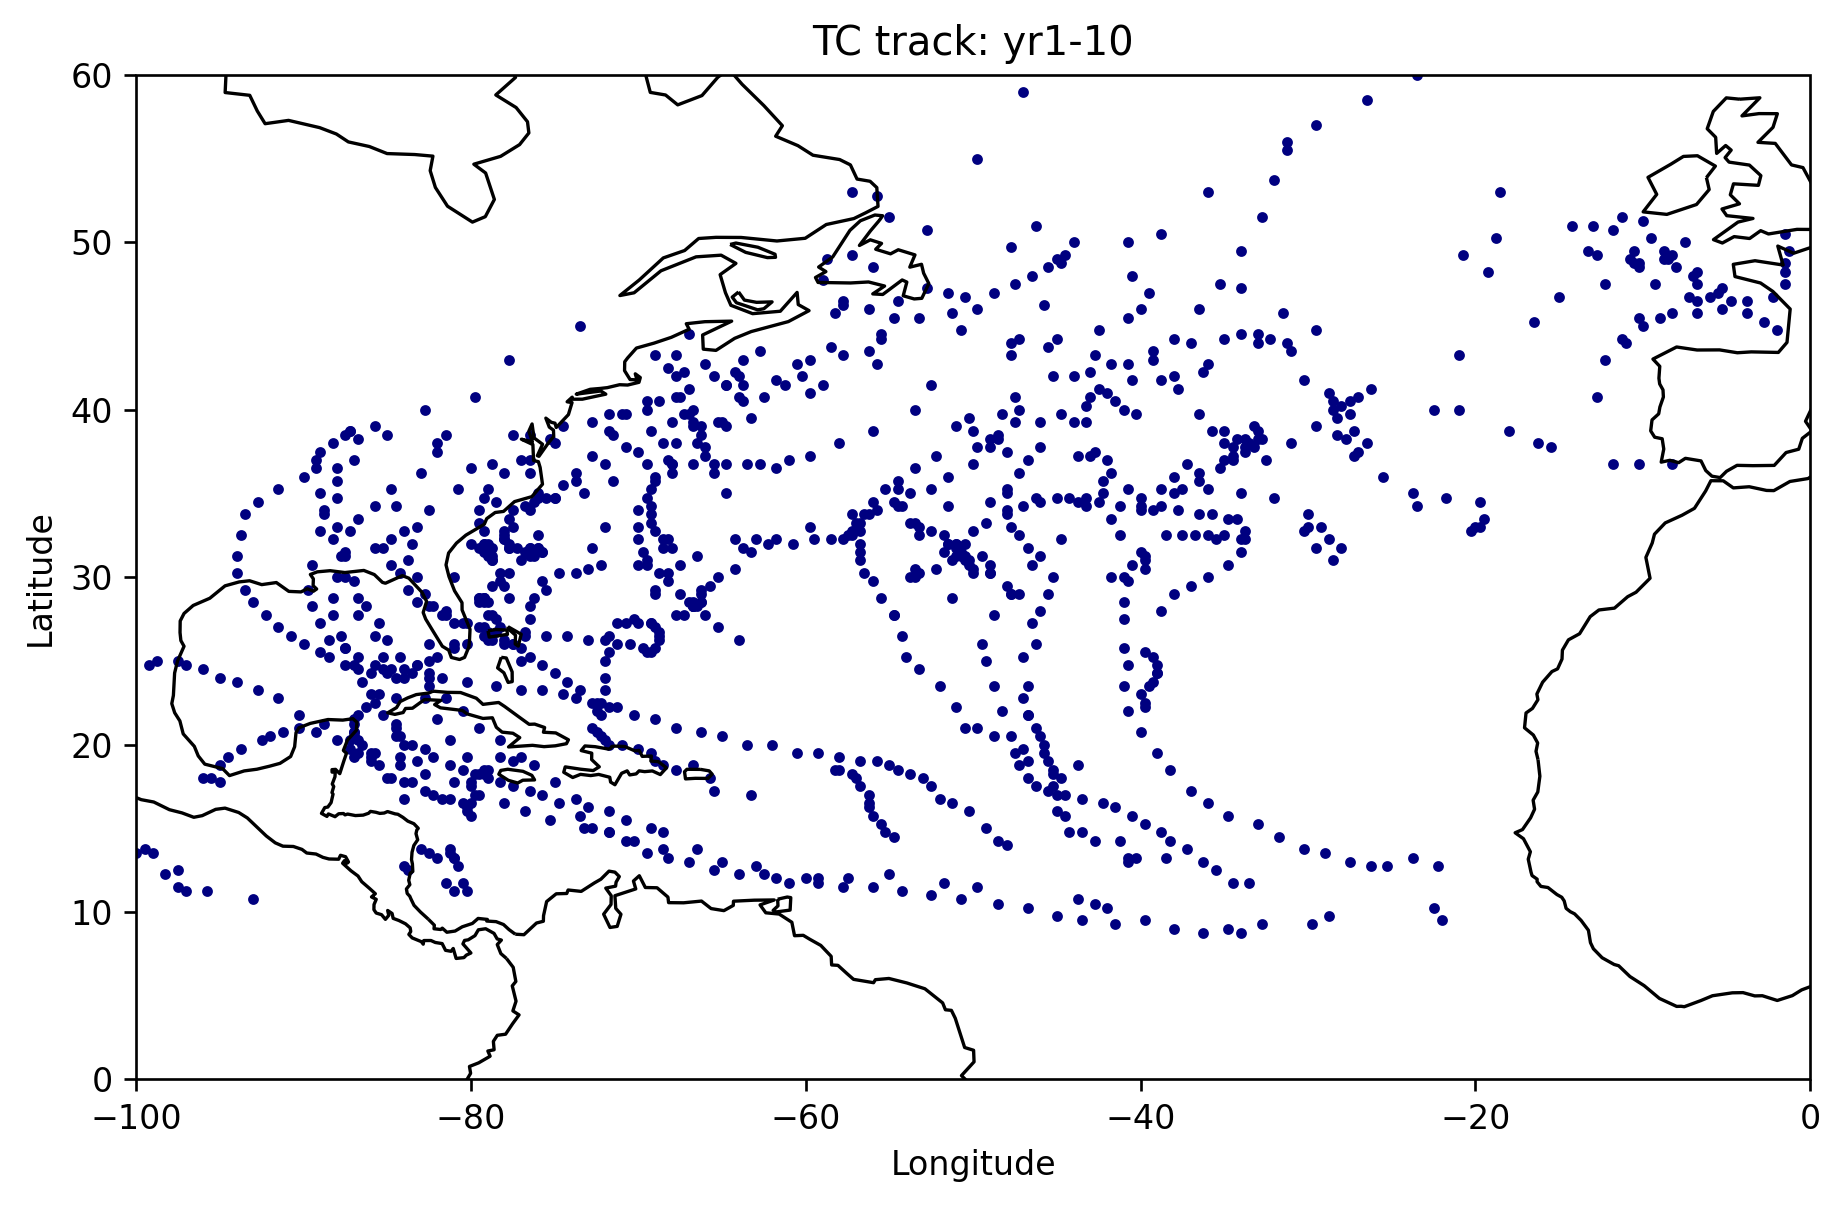

In [43]:


fig, axes = plt.subplots(nrows=1, ncols=1, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(9, 8.5))

plt.scatter(era5.lon, era5.lat, color='navy', s=5, transform=ccrs.PlateCarree())

axes.coastlines()
axes.set_xticks(np.arange(-100, 20, 20), crs=ccrs.PlateCarree())
axes.set_yticks(np.arange(0, 61, 10), crs=ccrs.PlateCarree())
axes.set_extent([-100, 0, 0, 60], crs=ccrs.PlateCarree())

plt.title('TC track: yr1-10')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()
